# Model-Tuning Report for Predictions by House/Interval

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

os.chdir('/home/max/gridcure_domino/')
from src.predict_EV_homes import features_by_house # not used but needed to unpickle gridsearch results
from predict_when_charging import add_interval_encodings, delta_features_by_signal_component, features_by_house_by_interval

/home/max/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Notebook Input(s)

In [2]:
grid_search_filepath = 'Model Tuning Results/gridsearch_when_charging_2_f1.pkl'
ylim = None #(default) #(0.88, 0.92)

### Load Results

In [3]:
with open(grid_search_filepath, 'rb') as handle:
    grid_search_results = pickle.load(handle) 

## Parameters Explored

In [4]:
grid_search_results.param_grid

{'clf__base_score': [0.01, 0.03, 0.5],
 'clf__max_depth': [2, 3, 5],
 'clf__n_estimators': [100],
 'clf__reg_alpha': [1, 2, 3],
 'featureGeneration__signal_components': [['resid', 'seasonal'],
  ['resid'],
  ['resid', 'trend', 'seasonal']]}

## Best  Parameters, Scores

In [5]:
grid_search_results.best_params_

{'clf__base_score': 0.03,
 'clf__max_depth': 5,
 'clf__n_estimators': 100,
 'clf__reg_alpha': 2,
 'featureGeneration__signal_components': ['resid', 'seasonal']}

In [6]:
# Get Dictionary of Arrays representing Model Results and Index of Best Model (by test-set accuracy)
results = grid_search_results.cv_results_
index_of_best_model = grid_search_results.best_index_

print('Test  Set F1-Score: ', results['mean_test_score'][index_of_best_model])
print('Train Set F1-Score: ', results['mean_train_score'][index_of_best_model])

Test  Set F1-Score:  0.709895736308
Train Set F1-Score:  0.778285007281


## Distribution of Scores by Parameter

### Define Plotting Function

In [7]:
def plot_scores_by_param_level(CV_search_object, param, categorical=True):
    '''Plot the distribution of Scores for Each Level of a Parameter Explored during Model Tuning'''
    
    if categorical==False:
        print("Haven't implemented this for non-categorical vars but should later. Please Re-run w/ categorical=True ")
        return
    
    # Get Param-Values, Train/Test Scores
    cv_results = CV_search_object.cv_results_

    param_values = pd.Series(cv_results['param_'+param].data)
    train_scores = pd.Series(cv_results['mean_train_score'])
    test_scores  = pd.Series(cv_results['mean_test_score'])

    # Create Separate DFs for train-scores, test-scores. 
    # Then Row-bind them together for easy charting with seaborn/hue
    train_scores = pd.DataFrame({'Param Value': param_values,
                                 'F-1 Score'   : train_scores, 
                                 'Scored On'  : 'Train'})

    test_scores  = pd.DataFrame({'Param Value': param_values,
                                 'F-1 Score'   : test_scores, 
                                 'Scored On'  : 'Test'})

    all_scores = pd.concat([train_scores, test_scores], axis=0)
    
    # Ensure 'param value' column is always type str (some entries are currently lists)
    all_scores['Param Value'] = all_scores['Param Value'].astype(str)

    # Create Plot
    ax = sns.stripplot(x="Param Value", 
                       y="F-1 Score", 
                       hue="Scored On",
                       #alpha=0.75,
                       data=all_scores, 
                       jitter=True)

    # Aesthetic Adjustments to Plot
    title = 'Distribution of Accuracy-Scores \n For Different Levels of ' + param
    ax.set_title(title)
    ax.set_xlabel(param)
    ax.legend(loc=1, borderaxespad=0.)
    
    ax.set_ylim(ylim)

    return ax

## Plot Distributions of Train/Test Scores, For Different Levels of Params

### XGB 'Base Score' (Global Bias)

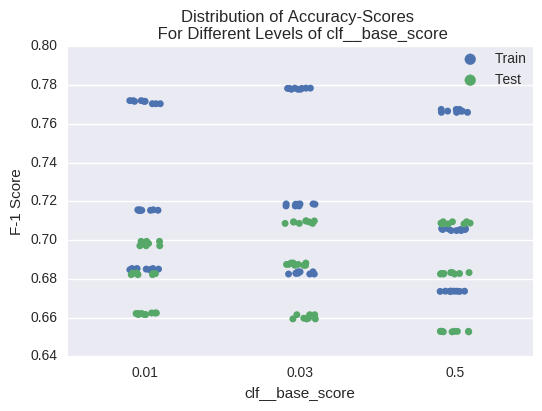

In [8]:
plot_scores_by_param_level(grid_search_results, 'clf__base_score')

### XGB Param Max-Depth

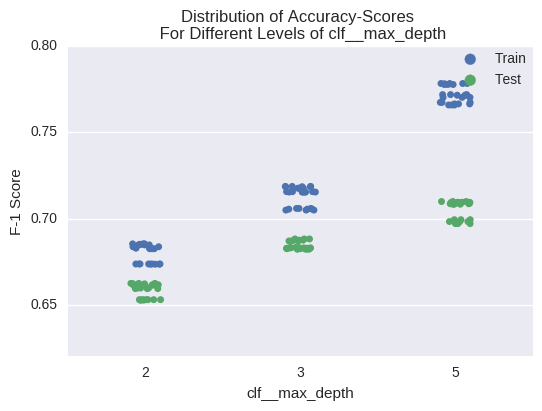

In [34]:
plot_scores_by_param_level(grid_search_results, 'clf__max_depth')       

### XGB Param Reg-Alpha (L1 Regularization Penalty)

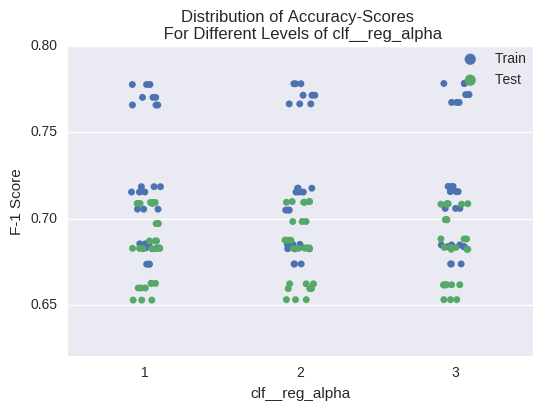

In [35]:
plot_scores_by_param_level(grid_search_results, 'clf__reg_alpha')       

### Feature Generation: Signal Componenets Used

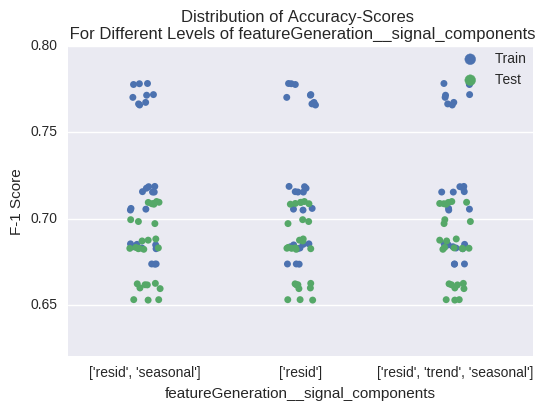

In [37]:
plot_scores_by_param_level(grid_search_results, 'featureGeneration__signal_components')       